In [102]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow_datasets.public_api as tfds

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [103]:
text_pairs = []

with open("data.tsv", "r", encoding="utf-8") as f:
    for line in f:
        # Strip any extra whitespace and split the line by tabs
        fields = line.strip().split("\t")
        # Ensure the line has at least 4 fields (indexes 0 to 3)
        if len(fields) < 4:
            continue
        french = fields[1]  # second column
        portuguese = "[start] " + fields[3] + " [end]"  # fourth column
        text_pairs.append((french, portuguese))

# Print the first pair to verify
print(text_pairs[0])

('Je ne supporte pas ce type.', '[start] Eu não suporto esse tipo. [end]')


In [104]:
for _ in range(5):
    print(random.choice(text_pairs))

('Les framboises sont chères en hiver.', '[start] As framboesas são caras no inverno. [end]')
("Il s'adonne au tennis, mais son frère aîné est plus porté par le football et le baseball.", '[start] Ele joga tênis, mas seu irmão mais velho gosta mais de futebol e basquetebol. [end]')
('Celui qui dort jusqu’à midi se met alors à cavaler.', '[start] Aquele que dorme até ao meio-dia põe-se depois a correr. [end]')
('Je te ferai un nouveau costume.', '[start] Vou te fazer um novo conjunto. [end]')
('Je ne suis pas un héros.', '[start] Não sou um herói. [end]')


In [105]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

33030 total pairs
23122 training pairs
4954 validation pairs
4954 test pairs


In [106]:
strip_chars = string.punctuation + "«" + "»"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 25000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


french_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
portuguese_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_french_texts = [pair[0] for pair in train_pairs]
train_portuguese_texts = [pair[1] for pair in train_pairs]
french_vectorization.adapt(train_french_texts)
portuguese_vectorization.adapt(train_portuguese_texts)

In [107]:
def format_dataset(french, portuguese):
    french = french_vectorization(french)
    portuguese = portuguese_vectorization(portuguese)
    return (
        {
            "encoder_inputs": french,
            "decoder_inputs": portuguese[:, :-1],
        },
        portuguese[:, 1:],
    )


def make_dataset(pairs):
    french_texts, portuguese_texts = zip(*pairs)
    french_texts = list(french_texts)
    portuguese_texts = list(portuguese_texts)
    dataset = tf_data.Dataset.from_tensor_slices((french_texts, portuguese_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [108]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2025-02-09 14:16:39.644161: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [109]:
print(train_french_texts[:5])
print(train_portuguese_texts[:5])

["Il est venu dans l'espoir de te voir.", "Ils m'ont demandé ce que je ferais à l'avenir.", 'Peut-on prendre des photos dans ce bâtiment ?', 'Je ne suis pas sûr. Ça dépend.', "Si j'avais des ailes, je volerais vers toi."]
['[start] Ele veio na esperança de te ver. [end]', '[start] Eles me perguntaram o que farei no futuro. [end]', '[start] Podemos tirar fotos neste prédio? [end]', '[start] Não tenho certeza. Depende. [end]', '[start] Se eu tivesse asas, voaria até você. [end]']


In [110]:
# Supondo que a classe de atenção Bahdanau já esteja definida corretamente:
class BahdanauAttention(layers.Layer):
    def __init__(self, units, verbose=0):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.verbose = verbose

    def call(self, query, values):
        # query: (batch_size, hidden_size)
        # values: (batch_size, time_steps, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))  # (batch_size, time_steps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, time_steps, 1)
        context_vector = attention_weights * values  # (batch_size, time_steps, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        return context_vector, attention_weights

# Camada customizada para aplicar a atenção para cada timestep do decoder
class TimeDistributedAttention(layers.Layer):
    def __init__(self, attention_layer, **kwargs):
        super(TimeDistributedAttention, self).__init__(**kwargs)
        self.attention_layer = attention_layer

    def call(self, inputs):
        # inputs é uma lista [decoder_outputs, encoder_outputs]
        # decoder_outputs: (batch_size, dec_timesteps, latentSpaceDimension)
        # encoder_outputs: (batch_size, enc_timesteps, latentSpaceDimension)
        decoder_outputs, encoder_outputs = inputs

        # Transpomos para que o eixo do tempo fique como primeiro eixo
        decoder_outputs_transposed = tf.transpose(decoder_outputs, perm=[1, 0, 2])  # (dec_timesteps, batch_size, latentSpaceDimension)

        # Para cada timestep do decoder, calcular o vetor de contexto usando o respectivo vetor (como query)
        def apply_attention(decoder_timestep):
            # decoder_timestep: (batch_size, latentSpaceDimension)
            # Usamos esse vetor como query para calcular a atenção em relação a todos os encoder_outputs
            context, _ = self.attention_layer(decoder_timestep, encoder_outputs)
            return context  # (batch_size, latentSpaceDimension)

        # Usa tf.map_fn para iterar sobre os timesteps
        context_sequence_transposed = tf.map_fn(
            apply_attention,
            decoder_outputs_transposed,
            fn_output_signature=tf.float32
        )
        # Transpomos de volta para ter (batch_size, dec_timesteps, latentSpaceDimension)
        context_sequence = tf.transpose(context_sequence_transposed, perm=[1, 0, 2])
        return context_sequence


In [111]:
latentSpaceDimension = 32

In [112]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Parameters
sequence_length = 20  # Maximum number of tokens per sequence
vocab_size = 15000    # Total number of tokens in your vocabulary
embed_dim = 128       # Dimension of each token embedding

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        # Get token embeddings: shape (batch_size, sequence_length, embed_dim)
        embedded_tokens = self.token_embeddings(inputs)
        # Create a constant tensor for positions: shape (sequence_length,)
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        # Get positional embeddings: shape (sequence_length, embed_dim)
        embedded_positions = self.position_embeddings(positions)
        # Expand dims to (1, sequence_length, embed_dim) so that it broadcasts over the batch
        embedded_positions = tf.expand_dims(embedded_positions, axis=0)
        # Return the sum of token and positional embeddings
        return embedded_tokens + embedded_positions


    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


In [113]:
class AttentionLSTMCell(layers.Layer):
    def __init__(self, units, attention_layer, dropout_rate=0.3, **kwargs):
        super(AttentionLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.attention_layer = attention_layer
        self.dropout_rate = dropout_rate
        self.lstm_cell = layers.LSTMCell(units)
    
    @property
    def state_size(self):
        return [self.units, self.units, self.units, tf.TensorShape([None, self.units])]
    
    @property
    def output_size(self):
        return self.units + self.units

    def call(self, inputs, states):
        # inputs: (batch_size, embed_dim)
        # states: [hidden, cell, prev_attention, encoder_outputs]
        hidden, cell, prev_attention, encoder_outputs = states
        
        # Concatena o embedding do token atual com o vetor de atenção do timestep anterior
        input_combined = tf.concat([inputs, prev_attention], axis=-1)
        
        # Aplica dropout na entrada combinada
        input_combined = tf.nn.dropout(input_combined, rate=self.dropout_rate)
        
        # Processa pela LSTMCell
        output, [new_hidden, new_cell] = self.lstm_cell(input_combined, [hidden, cell])
        
        # Calcula a atenção usando o novo estado oculto como query
        context_vector, attention_weights = self.attention_layer(new_hidden, encoder_outputs)
        
        # Concatena o novo estado oculto com o vetor de contexto para formar a saída
        new_output = tf.concat([new_hidden, context_vector], axis=-1)
        
        # Atualiza os estados (mantendo encoder_outputs inalterado)
        new_state = [new_hidden, new_cell, context_vector, encoder_outputs]
        return new_output, new_state

In [114]:
# --- Parâmetros e camadas de embedding (supondo que já estejam definidos) ---
# sequence_length, vocab_size, embed_dim, latentSpaceDimension

# Defina a camada densa para adaptar os outputs do encoder
encoder_adapter = layers.Dense(latentSpaceDimension, activation='relu', name='encoder_adapter')

# --- Encoder ---
encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
encoder_embed = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_lstm = layers.LSTM(latentSpaceDimension, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]  # estados finais do encoder

# Adapte os outputs do encoder
adapted_encoder_outputs = encoder_adapter(encoder_outputs)

# **Defina a camada de atenção**
attention_layer = BahdanauAttention(latentSpaceDimension, verbose=0)

# --- Decoder ---
decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
decoder_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)

# Cria o cell customizado com input feeding (utilizando o attention_layer definido acima)
attention_cell = AttentionLSTMCell(latentSpaceDimension, attention_layer)
decoder_rnn = layers.RNN(attention_cell, return_sequences=True, return_state=True)

# Inicializa o vetor de atenção com zeros
def get_initial_attention(x):
    batch_size = tf.shape(x)[0]
    return tf.zeros((batch_size, latentSpaceDimension), dtype=tf.float32)

initial_attention = layers.Lambda(get_initial_attention)(state_h)

# O estado inicial agora é composto por: [hidden, cell, prev_attention, adapted_encoder_outputs]
initial_state = encoder_states + [initial_attention, adapted_encoder_outputs]

# Executa a RNN do decoder
decoder_rnn_outputs = decoder_rnn(decoder_embeddings, initial_state=initial_state)
decoder_outputs = decoder_rnn_outputs[0]

# Camada densa final para gerar as predições
decoder_dense = layers.Dense(vocab_size, activation='softmax', name='decoder_dense')
final_outputs = decoder_dense(decoder_outputs)

/home/bruno/Documents/unb/tema/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'attention_lstm_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [115]:
# Camada densa final para gerar as predições
decoder_dense = layers.Dense(vocab_size, activation='softmax', name='decoder_dense')
final_outputs = decoder_dense(decoder_outputs)

# --- Modelo Final ---
model = Model([encoder_inputs, decoder_inputs], final_outputs, name='seq2seq_input_feeding')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "seq2seq_input_feeding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 128)   │  1,922,560 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 20, 32),  │     20,608 │ positional_embed… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, None, 128) │  1,920,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32)        │          0 │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_adapter     │ (None, 20, 32)    │      1,056 │ encoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_2 (RNN)         │ [(None, None,     │          0 │ embedding_27[0][… │
│                     │ 64), (None, 32),  │            │ encoder_lstm[0][… │
│                     │ (None, 32),       │            │ encoder_lstm[0][… │
│                     │ (None, 32)]       │            │ lambda_2[0][0],   │
│                     │                   │            │ encoder_adapter[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │    975,000 │ rnn_2[0][0]       │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,839,224 (18.46 MB)

 Trainable params: 4,839,224 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
import numpy as np

# =============================================================================
# Preparação dos arrays para treinamento e teste a partir dos textos brutos
# =============================================================================

# --- Dados de Treinamento ---
# Converte os textos de treinamento para arrays utilizando as camadas de vetorização
encoder_input_data = french_vectorization(np.array(train_french_texts)).numpy()
portuguese_tokenized = portuguese_vectorization(np.array(train_portuguese_texts)).numpy()

# Para o decoder, usamos:
# - decoder_input_data: todas as posições, exceto o último token (entrada para o decoder)
# - decoder_target_data: todas as posições, exceto o primeiro token (alvo que o modelo deve prever)
decoder_input_data = portuguese_tokenized[:, :-1]
decoder_target_data = portuguese_tokenized[:, 1:]

# --- Dados de Teste ---
# Extraímos os textos de teste e convertemos utilizando as camadas de vetorização
test_french_texts = [pair[0] for pair in test_pairs]
test_portuguese_texts = [pair[1] for pair in test_pairs]

encoder_input_test = french_vectorization(np.array(test_french_texts)).numpy()
portuguese_tokenized_test = portuguese_vectorization(np.array(test_portuguese_texts)).numpy()

decoder_input_test = portuguese_tokenized_test[:, :-1]
decoder_target_test = portuguese_tokenized_test[:, 1:]

# =============================================================================
# Treinamento e Avaliação do Modelo com a Nova Arquitetura (com atenção)
# =============================================================================

# Treina o modelo utilizando os arrays preparados.
history = model.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test)
)

# Avalia o modelo no conjunto de teste (caso haja um conjunto separado de validação)
test_loss, test_accuracy = model.evaluate(
    x=[encoder_input_test, decoder_input_test],
    y=decoder_target_test
)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 61s 160ms/step - accuracy: 0.6451 - loss: 4.5659 - val_accuracy: 0.7057 - val_loss: 2.1115
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.7070 - loss: 2.0548 - val_accuracy: 0.7167 - val_loss: 2.0031
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 57s 159ms/step - accuracy: 0.7208 - loss: 1.9006 - val_accuracy: 0.7302 - val_loss: 1.9038
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.7324 - loss: 1.7768 - val_accuracy: 0.7375 - val_loss: 1.8368
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.7417 - loss: 1.6586 - val_accuracy: 0.7451 - val_loss: 1.7936
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.7522 - loss: 1.5508 - val_accuracy: 0.7544 - val_loss: 1.7084
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.7632 - loss: 1.4519 - val_accuracy: 0.7649 - val_loss: 1.6480
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 62s 170ms/step - accuracy: 0.7762 - loss: 1

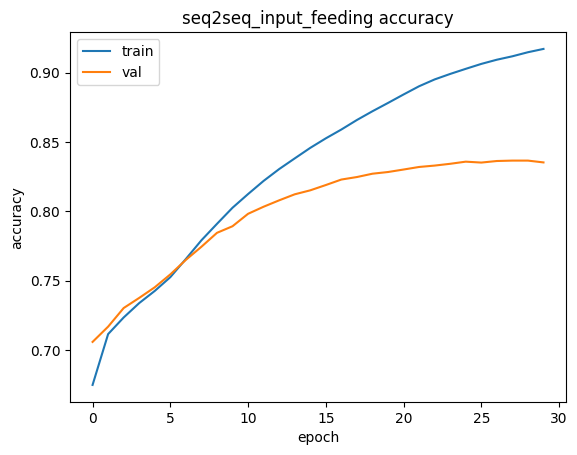

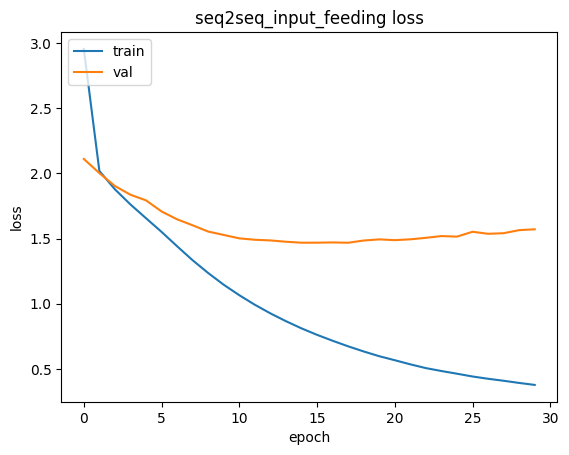

In [117]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(model.name+' accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(model.name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()